In [5]:
import io
import os
import re
import lzma
import pickle
import sys
import time
import torch

import matplotlib.patches as mpatches
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from torch.utils.data import Dataset
from glob import glob



In [3]:
time.strftime("%Y_%m_%d-%H_%M")

'2023_08_09-15_57'

Checking the raw data saved as pickle

In [19]:
lst = []
length = 0
for i in range(1, 201):
    raw_path = f"/home/aghazap/Desktop/SimulationExecutables/SimPilotExe_V14_0_0_B190_Highway3LanesOneway/data_M26/datafiles/PA_M26_FMD_1689723931_{i}.pkl"
    df_raw = pd.read_pickle(raw_path)
    lst.append(np.unique(df_raw["collision_type"]))
    length += len(df_raw.index)
    if 262144 in np.unique(df_raw["collision_type"]):
        print(df_raw[df_raw["collision_type"] == 262144])
    print(len(df_raw[(df_raw["left_lane_available"] == 0) & (df_raw["right_lane_available"] == 0)]))
    del df_raw
print(length / 200)

0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
     initials        time milestone task  eps  step  pythonTime  ego_speed  \
3957       PA  1689723931       M26  FMD   41  3957   79.807364  20.352108   
3958       PA  1689723931       M26  FMD   41  3958   79.823931  20.352108   

      position_x  position_y  ...  speed_limit  expert_type  collision_type  \
3957  828.974670 -288.396729  ...       20.375         Sumo        262144.0   
3958  828.939514 -288.802246  ...       20.375         Sumo        262144.0   

      left_lane_available  right_lane_available  allowed_speed  \
3957                  0.0                   0.0      22.006975   
3958                  1.0                   0.0      22.006975   

                                            movable_obj  speed_action  \
3957  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...      0.457865   
3958  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...      0.457865   

      lane_change_command 

In [5]:
vals = []
for ar in lst:
    for num in ar:
        vals.append(num)
np.unique(vals)

array([     0., 262144.], dtype=float32)

Checking the processed data saved as pickle

AttributeError: 'Figure' object has no attribute 'scatter'

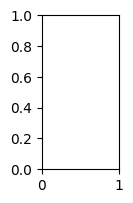

In [16]:
processed_path = "/home/aghazap/Desktop/SimulationExecutables/SimPilotExe_V14_0_2_B193_Highway3LanesOneway/data_M26/datafiles/PA_M26_FMD_1689723931_1.pkl"
df = pd.read_pickle(processed_path)
lst = df["movable_obj"]
lst[0][0]
fig, ax = plt.subplots(figsize=(1, 2))
rect = mpatches.Rectangle((-2, -3), 1, 8, fill=True, color="steelblue", linewidth=2)
for frame in lst:
    for i in range(20):
        if frame[i][0] != 0:
            fig.scatter(frame[i][2], frame[i][1], color='mediumvioletred', alpha=0.01)
fig.gca().add_patch(rect)
fig.title("Heatmap of vehicles around Ego")
plt.show()

In [4]:
def interpolate_array(arr, num_points):
    indices = np.linspace(0, len(arr) - 1, num_points)
    interpolated_values = np.interp(indices, range(len(arr)), arr)
    return interpolated_values
POLYFIT_THRESHOLD=0.00001
def compute_bezier(x_local, y_local, poly_points, time_based):

        x_val, y_val = x_local,y_local
        x_val = interpolate_array(x_val, poly_points)
        y_val = interpolate_array(y_val, poly_points)
        t_val = np.linspace(0, 2.5, 100)
        num_of_degrees = 17
        if sum(x_val) > POLYFIT_THRESHOLD:
            lowest_mse = -1
            top_deg = 0
            for degree in range(1, num_of_degrees):
                if time_based:
                    x_fit = np.polyfit(t_val, x_val, deg=degree)
                    func_x = np.poly1d(x_fit)
                    x_new = func_x(t_val)
                    y_fit = np.polyfit(t_val, y_val, deg=degree)
                    func_y = np.poly1d(y_fit)
                    y_new = func_y(t_val)
                else:
                    z_fit = np.polyfit(x_val, y_val, deg=degree)
                    func = np.poly1d(z_fit)
                    x_new = np.linspace(x_val[0], x_val[-1], poly_points)
                    y_new = func(x_new)
                    xsqrd = (x_val - x_new) ** 2
                    ysqrd = (y_val - y_new) ** 2
                    total_mse = np.sqrt(xsqrd + ysqrd).mean()
                    if total_mse < lowest_mse or lowest_mse == -1:
                        lowest_mse = total_mse
                        top_deg = degree
                    print(degree, total_mse)

            z_fit = np.polyfit(x_val, y_val, deg=top_deg)
            func = np.poly1d(z_fit)
            x_new = np.linspace(x_val[0], x_val[-1], poly_points)
            y_new = func(x_new)
        else:
            x_new = np.zeros(poly_points)
            y_new = np.zeros(poly_points)
        return x_new, y_new

1 0.4949495111752039
2 0.4949495111752039
3 0.4949495111752039
4 0.4949495111752039
5 0.4949495111752039
6 0.4949495111752039
7 0.4949495111752039
8 0.4949495111752039
9 0.4949495111752039
10 0.4949495111752039
11 0.4949495111752039
12 0.4949495111752039
13 0.4949495111752039
14 0.4949495111752039
15 0.4949495111752039
16 0.4949495111752039
[0.   0.1  0.45 1.05 1.9  3.  ]
[ 0.  0.  0.  0.  0. -0.]


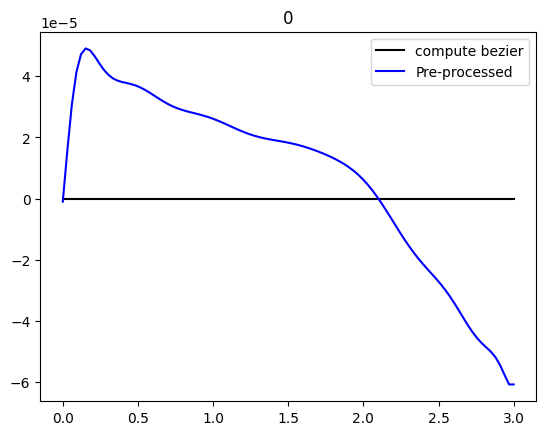

In [10]:
len(df_processed.index)
ind = 0
x = df_processed.loc[ind, "future_x_local_array"]
y = df_processed.loc[ind, "future_y_local_array"]
x = np.insert(x, 0, 0)
y = np.insert(y, 0, 0)
# print(df_processed.loc[ind, "future_x_local_array"])
# print(df_processed.loc[ind, "future_y_local_array"])
# print(df_processed.loc[ind, "future_points"])
xx_new, yy_new = compute_bezier(x, y, 100, False)
plt.plot(xx_new, yy_new, c='black', label='compute bezier')

plt.plot(df_processed.loc[ind, "future_points"][:100], df_processed.loc[ind, "future_points"][100:200], c='b', label="Pre-processed")
plt.plot(x, y, c='orange', label="Groundtruth")
print(x)
print(y)
# plt.plot(x, y_new, c='red', label="Polyfit only")
x = interpolate_array(x, 100)
y = interpolate_array(y, 100)

# plt.plot(x, y, c='g', label="Inteprolated")

z = np.polyfit(x, y, deg=1)
func = np.poly1d(z)
y_new = func(x)
# plt.plot(x, y_new, c='pink', label="Polyfit interpolated")
plt_name = df_processed.loc[ind, "step"]
plt.title(plt_name)
plt.legend()

In [ ]:
plt.hist(df_processed["ego_speed"])

In [ ]:
spawn_points = pd.read_csv("/home/aghazap/Desktop/SimulationExecutables/SimPilotExe_V12_0_2_B172_Highway3LanesOneway/cpc_aitp_imitation/scenedata/newspawnpoints.csv")
error_points = pd.read_csv("/home/aghazap/Desktop/SimulationExecutables/SimPilotExe_V12_0_2_B172_Highway3LanesOneway/error_points.csv")

In [ ]:
init_points = df_processed[df_processed["ego_speed"] < 0.01]

In [ ]:
plt.scatter(spawn_points["px"], spawn_points["py"], color="r", label="spawn points")
plt.scatter(error_points["px"], error_points["py"], color="g", label="error points")
# plt.scatter(init_points["position_x"], init_points["position_y"], color='b', label="positions")
plt.legend()
plt.show()

In [ ]:
os.system("ls -lh ./data/csvfiles/")

Checking Images

In [ ]:
fig = plt.subplots(1, 3, figsize = (5, 4))
images_path = "/home/aghazap/Desktop/SimulationExecutables/SimPilotExe_V9_1_3_B109_OSCOval/data/images"

ind = 1
for directory in os.listdir(images_path):
    if directory[-1] == "2":
        image_name = sorted(os.listdir(os.path.join(images_path, directory)))[200]
        image = plt.imread(os.path.join(images_path, directory, image_name))
        
        plt.subplot(1, 3, ind)
        plt.axis("off")
        plt.title(image_name.split("_")[0])
        plt.imshow(image, cmap="plasma")

        ind+=1
        
plt.show()